In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import esm
import evoVAE.utils.seq_tools as st
from evoVAE.utils.datasets import MSA_Dataset
from evoVAE.models.seqVAE import SeqVAE
import yaml
import evoVAE.utils.visualisation as vs 
from sklearn.linear_model import LassoLars, Ridge
from typing import Tuple
#dms_path = "/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/"

In [2]:
torch.cuda.is_available()

True

This notebook uses the ESM2 package to get sequence embeddings and then fits a regressor to this data

I have to use the unaligned sequences because gaps are not included as tokens. 

First I'm going to use the MAFG variant dataset

reference:
ESM GitHub: https://github.com/facebookresearch/esm

Supervised learning pipeline: https://colab.research.google.com/github/facebookresearch/esm/blob/main/examples/sup_variant_prediction.ipynb#scrollTo=8MpZ87vEbo4b

In [3]:
def get_transformer_embeddings(model, alphabet, batch_converter, data, device, model_layer=-1) -> pd.DataFrame:
    """Get mean representation of sequence"""

    id_seq_pair = [(id, seq) for id, seq in zip(data["mutant"], data["mutated_sequence"])]
    batch_labels, batch_strs, batch_tokens = batch_converter(id_seq_pair)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
    batch_tokens = batch_tokens.to(device)
    
    # Extract per-residue representations (on CPU)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[model_layer])
    token_representations = results["representations"][model_layer]
    print("Token shape")
    # (num_variants, seq_len_with_start/end_tokens, residue embedding length)
    print(token_representations.shape)

    # Generate per-sequence representations via averaging
    # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1. Last token is special token that is ignored as well
    sequence_representations = []
    for i, tokens_len in enumerate(batch_lens):
        sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0).cpu())

    embeddings = pd.DataFrame({"mutant": batch_labels, "embedding": sequence_representations})

    return embeddings

def perform_grid_search(train_data, test_data, classifier_classes: list, 
                        grid_parameters: list, pipeline: Pipeline, cv=10) -> Tuple[list, list]:
    result_list = []
    grid_list = []
    for cls_name, param_grid in zip(classifier_classes, grid_parameters):
        print(cls_name)
        grid = GridSearchCV(
            estimator = pipeline,
            param_grid = param_grid,
            scoring = 'r2',
            verbose = 0,
            cv=cv,
            n_jobs = -1 # use all available cores
        )

        grid.fit(train_data, test_data)
        result_list.append(pd.DataFrame.from_dict(grid.cv_results_))
        grid_list.append(grid)

    return result_list, grid_list

def setup_loader(data, device):
    
    dataset = MSA_Dataset(
        data["one_hot"],
        np.arange(len(data["one_hot"])),
        data["mutant"],
        device=device,      
    )
    
    print(f"Dataset size: {len(dataset)}")

    loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    return loader

def instantiate_model(seq_len, device, state_dict, settings):
    
    model = SeqVAE(dim_latent_vars=settings["latent_dims"],
                dim_msa_vars= (seq_len * 21), 
                num_hidden_units=settings["hidden_dims"],
                settings=settings,
                num_aa_type=settings["AA_count"])

    model = model.to(device)
    model.load_state_dict(torch.load(state_dict, map_location=device))
    return model 


def instantiate_top_models_and_pipe():
    ridge_grid = [
        {
            'model': [Ridge()],
            'model__alpha': np.logspace(-6, 6, 1000),
            'model__solver': ["auto"]
        }
    ]

    lasso_grid = [
        {
            'model': [LassoLars()],
            'model__alpha': np.logspace(-6, 6, 1000),
        }
    ]

    cls_list = [Ridge, LassoLars]
    param_grid_list = [ridge_grid, lasso_grid]

    pipe = Pipeline(
        steps = [
            ('model', 'passthrough')
        ]
    )

    return cls_list, param_grid_list, pipe

def one_hot_top_model(train_data, test_data):
    xs_train = np.array([st.seq_to_one_hot(x).flatten() for x in  train_data["mutated_sequence"]])
    ys_train = np.array([float(y) for y in train_data["DMS_score"]])
    xs_test = np.array([st.seq_to_one_hot(x).flatten() for x in  test_data["mutated_sequence"]])
    ys_test = np.array([float(y) for y in test_data["DMS_score"]])

    cls_list, param_grid_list, pipe = instantiate_top_models_and_pipe()

    results, grids = perform_grid_search(xs_train, ys_train, cls_list, param_grid_list, pipe)
    for grid in grids:
        print(grid.best_estimator_.get_params()["steps"][0][1]) # get the model details from the estimator
        print()
        preds = grid.predict(xs_test)
        print(f'{scipy.stats.spearmanr(ys_test, preds)}')
        print('\n', '-' * 80, '\n')

    return results, grids

# MAFG

In [4]:
dms_path = "/scratch/user/s4646506/mafg/dms_data/"
mafg_variants = pd.read_csv(dms_path + "MAFG_MOUSE_Tsuboyama_2023_1K1V.csv")
mafg_variants["one_hot"] = mafg_variants["mutated_sequence"].apply(st.seq_to_one_hot)
mafg_variants

,mutant,mutated_sequence,DMS_score,DMS_score_bin,one_hot
0,D3A,LTAEELVTMSVRELNQHLRGLSKEEIIQLKQRRRTLKNRGY,-1.274690,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,D3A:R32A,LTAEELVTMSVRELNQHLRGLSKEEIIQLKQARRTLKNRGY,-1.637233,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,D3A:R32C,LTAEELVTMSVRELNQHLRGLSKEEIIQLKQCRRTLKNRGY,-1.081258,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,D3A:R32D,LTAEELVTMSVRELNQHLRGLSKEEIIQLKQDRRTLKNRGY,-1.938164,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,D3A:R32E,LTAEELVTMSVRELNQHLRGLSKEEIIQLKQERRTLKNRGY,-1.893906,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...
1424,Y41R,LTDEELVTMSVRELNQHLRGLSKEEIIQLKQRRRTLKNRGR,-0.184325,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1425,Y41S,LTDEELVTMSVRELNQHLRGLSKEEIIQLKQRRRTLKNRGS,0.064654,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1426,Y41T,LTDEELVTMSVRELNQHLRGLSKEEIIQLKQRRRTLKNRGT,0.104944,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1427,Y41V,LTDEELVTMSVRELNQHLRGLSKEEIIQLKQRRRTLKNRGV,0.139744,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [6]:
mafg_train, mafg_test = train_test_split(mafg_variants, train_size=0.8, random_state=42)
mafg_train.shape, mafg_test.shape

((1143, 5), (286, 5))

### ESM2

Using the smallest model with 8M parameters, 6 layers trained on UniRef50.
Has 320 embedding dimensions.

In [7]:
### GET MEAN EMBEDDINGS ###
device = torch.device("cuda")
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()
model = model.to(device)
model.eval()

train_mafg_esm = get_transformer_embeddings(model, alphabet, batch_converter, mafg_train, model_layer=6, device=device)
mafg_train = mafg_train.merge(train_mafg_esm, on="mutant")
test_mafg_esm = get_transformer_embeddings(model, alphabet, batch_converter, mafg_test, model_layer=6, device=device)
mafg_test = mafg_test.merge(test_mafg_esm, on="mutant")

Token shape
torch.Size([1143, 43, 320])
Token shape
torch.Size([286, 43, 320])


In [8]:
### Turn into arrays for learning/visualisation ###


mafg_Xs_train = np.stack(mafg_train["embedding"])

mafg_ys_train = np.array([float(y) for y in mafg_train["DMS_score"]])

mafg_Xs_test = np.stack(mafg_train["embedding"])

mafg_ys_test = np.array([float(y) for y in mafg_train["DMS_score"]])


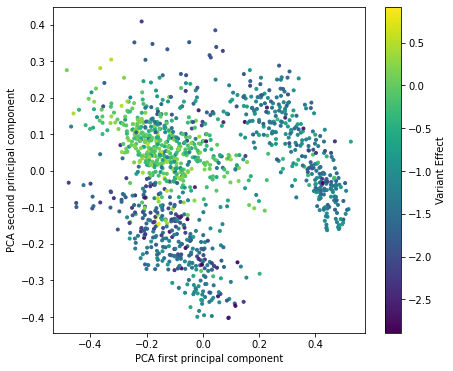

In [9]:
### Visualise what information the embeddings have captured ###
num_pca_components = 50
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(mafg_Xs_train)

fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=mafg_ys_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')

In [10]:
### Perform grid search for Lasso and Ridge regression ### 
cls_list, param_grid_list, pipe = instantiate_top_models_and_pipe()

results, grids = perform_grid_search(mafg_Xs_train, mafg_ys_train, cls_list, param_grid_list, pipe)
for grid in grids:
    print(grid.best_estimator_.get_params()["steps"][0][1]) # get the model details from the estimator
    print()
    preds = grid.predict(mafg_Xs_test)
    print(f'{scipy.stats.spearmanr(mafg_ys_test, preds)}')
    print('\n', '-' * 80, '\n')

# Ridge results
#results[0].sort_values('rank_test_score')[:5]
# LassoLARS results
#results[1].sort_values('rank_test_score')[:5]

<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.linear_model._least_angle.LassoLars'>
Ridge(alpha=0.002245697995539774)

SignificanceResult(statistic=0.9505269691122663, pvalue=0.0)

 -------------------------------------------------------------------------------- 

LassoLars(alpha=1.2052609368708414e-05)

SignificanceResult(statistic=0.9491227006878509, pvalue=0.0)

 -------------------------------------------------------------------------------- 



### One-hot encodings

In [ ]:
cls_list, param_grid_list, pipe = instantiate_top_models_and_pipe()


mafg_oh_xs_train = np.array([st.seq_to_one_hot(x).flatten() for x in  mafg_train["mutated_sequence"]])
print(mafg_oh_xs_train.shape)
mafg_oh_ys_train = np.array([float(y) for y in mafg_train["DMS_score"]])
print(mafg_oh_ys_train.shape)

mafg_oh_xs_test = np.array([st.seq_to_one_hot(x).flatten() for x in  mafg_test["mutated_sequence"]])
print(mafg_oh_xs_test.shape)
mafg_oh_ys_test = np.array([float(y) for y in mafg_test["DMS_score"]])
print(mafg_oh_ys_test.shape)

results, grids = perform_grid_search(mafg_oh_xs_train, mafg_oh_ys_train, cls_list, param_grid_list, pipe)
for grid in grids:
    print(grid.best_estimator_.get_params()["steps"][0][1]) # get the model details from the estimator
    print()
    preds = grid.predict(mafg_oh_xs_test)
    print(f'{scipy.stats.spearmanr(mafg_oh_ys_test, preds)}')
    print('\n', '-' * 80, '\n')

# Ridge results
#results[0].sort_values('rank_test_score')[:5]
# LassoLARS results
#results[1].sort_values('rank_test_score')[:5]


### VAE-MAP 

In [26]:
def pca_vis(xs, ys, title, num_pca_components = 2):
    ### Visualise the a PCA of the VAE latent space
    pca = PCA(num_pca_components)
    Xs_train_pca = pca.fit_transform(xs)

    fig_dims = (7, 6)
    fig, ax = plt.subplots(figsize=fig_dims)
    sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys, marker='.')
    ax.set_title(title)
    ax.set_xlabel(f'PCA1 ({round(pca.explained_variance_[0] * 100, 2)}%)')
    ax.set_ylabel(f'PCA2 ({round(pca.explained_variance_[1] * 100, 2)}%)')
    plt.colorbar(sc, label='Variant Effect')

def get_vae_latent(model, loader, orig_data):
    
    latent = vs.get_mu(model, loader)
    latent.rename(columns={"id": "mutant"}, inplace=True)
    latent = latent.merge(orig_data[["mutant", "DMS_score"]], on="mutant")

    return latent

def create_vae_data(model, loader, orig_data):

    latent = get_vae_latent(model, loader, orig_data)    
    Xs_train = np.stack(latent["mu"])

    #print("Xs")
    #print(Xs_train.shape)
    ys_train = np.array([float(y) for y in latent["DMS_score"]])
    ##print("ys")
    #print(ys_train.shape)

    return Xs_train, ys_train


def train_and_fit_vae_top_model(train_data, test_data, states, labels, protein, cls_list, param_grid_list, pipe, settings):
    
    device = torch.device("mps")
    train_loader = setup_loader(train_data, device)
    test_loader = setup_loader(test_data, device)

    for state, label in zip(states, labels): 
        print(label)
        seq_len = len(train_data["mutated_sequence"].values[0])
        model = instantiate_model(seq_len, device, state, settings)

        Xs_train, ys_train = create_vae_data(model, train_loader, train_data)
        Xs_test,  ys_test = create_vae_data(model, test_loader, test_data)

        pca_vis(Xs_train, ys_train, f"{protein} {label} model")

        results, grids = perform_grid_search(Xs_train, ys_train, cls_list, param_grid_list, pipe)
        for grid in grids:
            print(grid.best_estimator_.get_params()["steps"][0][1]) # get the model details from the estimator
            print()
            preds = grid.predict(Xs_test)
            print(f'{scipy.stats.spearmanr(ys_test, preds)}')
            print('\n', '-' * 80, '\n')

    return results, grids

### MAFG ancestors/extant models

In [27]:
# read in dummy config with correct dimensions 
with open("../data/dummy_config_50_latent.yaml", "r") as stream:
    settings = yaml.safe_load(stream)

cls_list, param_grid_list, pipe = instantiate_top_models_and_pipe()

a_state_dict = "/Users/sebs_mac/50_latent/mafg_a/mafg_a_r1_fold_1_model_state.pt"
e_state_dict = "/Users/sebs_mac/50_latent/mafg_e/mafg_e_r1_fold_1_model_state.pt"
states = [a_state_dict, e_state_dict]
labels = ["Ancestors", "Extants"]

results, grids = train_and_fit_vae_top_model(mafg_train, mafg_test, states, labels, "MAFG",
                                              cls_list, param_grid_list, pipe, settings)


FileNotFoundError: [Errno 2] No such file or directory: '../data/dummy_config_50_latent.yaml'

### MAFG clusters

In [ ]:
with open("../data/dummy_config.yaml", "r") as stream:
    settings = yaml.safe_load(stream)


cls_list, param_grid_list, pipe = instantiate_top_models_and_pipe()

data_path = "/Users/sebs_mac/uni_OneDrive/honours/data/seb_clustering_results/mafg_clusters/"

labels = [0.0, 0.05, 0.1, 0.15]

states = [data_path + f"mafg_{prop}/mafg_{prop}_r1/mafg_{prop}_r1_model_state.pt" for prop in labels]
results, grids = train_and_fit_vae_top_model(mafg_train, mafg_test, states, labels, "MAFG",
                                               cls_list, param_grid_list, pipe, settings)


# GCN4 


In [11]:
dms_path = "/scratch/user/s4646506/gcn4/dms_data/"
gcn4_variants = pd.read_csv(dms_path + "GCN4_YEAST_Staller_2018.csv")
gcn4_variants["one_hot"] = gcn4_variants["mutated_sequence"].apply(st.seq_to_one_hot)
gcn4_variants.head()

,mutant,mutated_sequence,DMS_score,DMS_score_bin,one_hot
0,D103A,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.543932,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,D103A:F108N:K118D:S122Q:V135I:D139W,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.158042,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,D103A:S104T:T105I:P106T:M107L:F108T:E109S:N112...,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.391235,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,D103A:S122A:V130Q:T132M:S144N,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.243840,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,D103A:S122E:S136P:K140S:A141R,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.678492,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [12]:
gcn4_train, gcn4_test = train_test_split(gcn4_variants, train_size=0.8, random_state=42)
gcn4_train.shape, gcn4_test.shape

((2110, 5), (528, 5))

### ESM2

In [13]:
gnc4_model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()
gnc4_model = gnc4_model.to(device)
gnc4_model.eval()

train_gcn4_esm = get_transformer_embeddings(gnc4_model, alphabet, batch_converter, gcn4_train, model_layer=6, device=device)
gcn4_train = gcn4_train.merge(train_gcn4_esm, on="mutant")

test_gcn4_esm = get_transformer_embeddings(gnc4_model, alphabet, batch_converter, gcn4_test, model_layer=6, device=device)
gcn4_test = gcn4_test.merge(test_gcn4_esm, on="mutant")

Token shape
torch.Size([2110, 283, 320])
Token shape
torch.Size([528, 283, 320])


In [14]:
### Turn into arrays for learning/visualisation ###

print("Train data created")
gcn4_Xs_train = np.stack(gcn4_train["embedding"])
gcn4_ys_train = np.array([float(y) for y in gcn4_train["DMS_score"]])

print("Test data created")
gcn4_Xs_test = np.stack(gcn4_train["embedding"])
gcn4_ys_test = np.array([float(y) for y in gcn4_train["DMS_score"]])


Train data created
Test data created


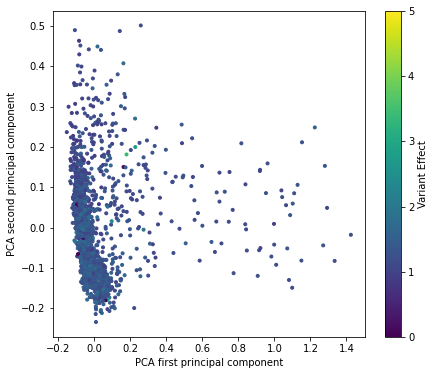

In [15]:
### Visualise what information the embeddings have captured ###
num_pca_components = 50
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(gcn4_Xs_train)

fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=gcn4_ys_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')

In [16]:

cls_list, param_grid_list, pipe = instantiate_top_models_and_pipe()

results, grids = perform_grid_search(gcn4_Xs_train, gcn4_ys_train, cls_list, param_grid_list, pipe)
for grid in grids:
    print(grid.best_estimator_.get_params()["steps"][0][1]) # get the model details from the estimator
    print()
    preds = grid.predict(gcn4_Xs_test)
    print(f'{scipy.stats.spearmanr(gcn4_ys_test, preds)}')
    print('\n', '-' * 80, '\n')


<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.linear_model._least_angle.LassoLars'>
Ridge(alpha=0.055557762223988776)

SignificanceResult(statistic=0.5845709956038415, pvalue=1.189316223255225e-193)

 -------------------------------------------------------------------------------- 

LassoLars(alpha=2.840883690183301e-05)

SignificanceResult(statistic=0.5654522334236953, pvalue=1.34598341464721e-178)

 -------------------------------------------------------------------------------- 



### One-Hot

In [ ]:
gcn4_oh_xs_train = np.array([st.seq_to_one_hot(x).flatten() for x in  gcn4_train["mutated_sequence"]])
gcn4_oh_ys_train = np.array([float(y) for y in gcn4_train["DMS_score"]])

gcn4_oh_xs_test = np.array([st.seq_to_one_hot(x).flatten() for x in  gcn4_test["mutated_sequence"]])
gcn4_oh_ys_test = np.array([float(y) for y in gcn4_test["DMS_score"]])


In [ ]:
cls_list, param_grid_list, pipe = instantiate_top_models_and_pipe()

results, grids = perform_grid_search(gcn4_oh_xs_train, gcn4_oh_ys_train, cls_list, param_grid_list, pipe)
for grid in grids:
    print(grid.best_estimator_.get_params()["steps"][0][1]) # get the model details from the estimator
    print()
    preds = grid.predict(gcn4_oh_xs_test)
    print(f'{scipy.stats.spearmanr(gcn4_oh_ys_test, preds)}')
    print('\n', '-' * 80, '\n')

### VAE-MAP

### Ancestor/extant models

In [ ]:
# read in dummy config with correct dimensions 
with open("../data/dummy_config_50_latent.yaml", "r") as stream:
    settings = yaml.safe_load(stream)

# Top model grid search params 
cls_list, param_grid_list, pipe = instantiate_top_models_and_pipe()

# set up the dataloaders 
device = torch.device("mps")
gcn4_a_state_dict = "/Users/sebs_mac/50_latent/gcn4_a/gcn4_a_r1_fold_1_model_state.pt"
gcn4_e_state_dict = "/Users/sebs_mac/50_latent/gcn4_e/gcn4_e_r1_fold_1_model_state.pt"

states = [gcn4_a_state_dict, gcn4_e_state_dict]
labels = ["Ancestors", "Extants"]

results, grids = train_and_fit_vae_top_model(gcn4_train, gcn4_test, states, labels, "GCN4",
                                              cls_list, param_grid_list, pipe, settings)


### GCN4 clusters

In [ ]:
with open("../data/dummy_config.yaml", "r") as stream:
    settings = yaml.safe_load(stream)

data_path = "/Users/sebs_mac/uni_OneDrive/honours/data/seb_clustering_results/gcn4_seb_clusters/"

labels = [0.0, 0.02, 0.04, 0.06]

states = [data_path + f"gcn4_{prop}/gcn4_{prop}_extants_r1/gcn4_{prop}_extants_r1_model_state.pt" for prop in labels]

results, grids = train_and_fit_vae_top_model(gcn4_train, gcn4_test, states, labels, "GCN4",
                                               cls_list, param_grid_list, pipe, settings)


# GFP 

In [16]:
dms_path = "/scratch/user/s4646506/gfp/dms_data/"
gfp_variants = pd.read_csv(dms_path + "GFP_AEQVI_Sarkisyan_2016.csv")
gfp_variants["one_hot"] = gfp_variants["mutated_sequence"].apply(st.seq_to_one_hot)
gfp_variants.head()

,mutant,mutated_sequence,DMS_score,DMS_score_bin,one_hot
0,K3R:V55A:Q94R:A110T:D117G:M153K:D216A,MSRGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,1.301030,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,K3Q:V16A:I167T:L195Q,MSQGEELFTGVVPILAELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.137350,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,K3Q:Y143C:N164D:S205P:A227T,MSQGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,1.553913,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,K3Q:Y143N:V193A,MSQGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.404237,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,K3R,MSRGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.738586,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [17]:
gfp_train, gfp_test = train_test_split(gfp_variants, train_size=0.8, random_state=42)
gfp_train.shape, gfp_test.shape

((41371, 5), (10343, 5))

### ESM2

In [18]:
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()
model = model.to(device)
model.eval()
train_gfp_esm = get_transformer_embeddings(model, alphabet, batch_converter, gfp_train, model_layer=6, device=device)
gfp_train = gfp_train.merge(train_mafg_esm, on="mutant")

test_gfp_esm = get_transformer_embeddings(model, alphabet, batch_converter, gfp_test, model_layer=6, device=device)
gfp_test = gfp_test.merge(test_gfp_esm, on="mutant")

RuntimeError: HIP error: invalid configuration argument
HIP kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing AMD_SERIALIZE_KERNEL=3.
Compile with `TORCH_USE_HIP_DSA` to enable device-side assertions.


In [ ]:
print("Train data created")
gfp_Xs_train = np.stack(gfp_train["embedding"])
gfp_ys_train = np.array([float(y) for y in gfp_train["DMS_score"]])

print("Test data created")
gfp_Xs_test = np.stack(gfp_train["embedding"])
gfp_ys_test = np.array([float(y) for y in gfp_train["DMS_score"]])

cls_list, param_grid_list, pipe = instantiate_top_models_and_pipe()

results, grids = perform_grid_search(gfp_Xs_train, gfp_ys_train, cls_list, param_grid_list, pipe)
for grid in grids:
    print(grid.best_estimator_.get_params()["steps"][0][1]) # get the model details from the estimator
    print()
    preds = grid.predict(gcn4_Xs_test)
    print(f'{scipy.stats.spearmanr(gcn4_ys_test, preds)}')
    print('\n', '-' * 80, '\n')

In [ ]:
### Visualise what information the embeddings have captured ###
num_pca_components = 50
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(gfp_Xs_train)

fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=gcn4_ys_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')

### One-hot

In [ ]:
results, grids = one_hot_top_model(gfp_train, gfp_test)

### GFP ancestors/extant models

In [ ]:
# read in dummy config with correct dimensions 
with open("../data/dummy_config_50_latent.yaml", "r") as stream:
    settings = yaml.safe_load(stream)

cls_list, param_grid_list, pipe = instantiate_top_models_and_pipe()

a_state_dict = "/Users/sebs_mac/50_latent/gfp_a/gfp_a_r1_wd_0.0_model_state.pt"
e_state_dict = "/Users/sebs_mac/50_latent/gfp_e/gfp_e_r1_wd_0.0_model_state.pt"
states = [a_state_dict, e_state_dict]
labels = ["Ancestors", "Extants"]

results, grids = train_and_fit_vae_top_model(gfp_train, gfp_test, states, labels, "GFP",
                                              cls_list, param_grid_list, pipe, settings)


### GFP Clustering

In [ ]:
with open("../data/dummy_config.yaml", "r") as stream:
    settings = yaml.safe_load(stream)

cls_list, param_grid_list, pipe = instantiate_top_models_and_pipe()

data_path = "/Users/sebs_mac/uni_OneDrive/honours/data/seb_clustering_results/gfp_seb_clusters/"

labels = [0.0, 0.05, 0.1, 0.15, 0.2]

states = [data_path + f"gfp_{prop}/gfp_{prop}_extants_r1/gfp_{prop}_extants_r1_model_state.pt" for prop in labels]
results, grids = train_and_fit_vae_top_model(gfp_train, gfp_test, states, labels, "GFP",
                                               cls_list, param_grid_list, pipe, settings)

# A4

In [20]:
dms_path = "/scratch/user/s4646506/a4/dms_data/"
a4_variants = pd.read_csv(dms_path + "A4_HUMAN_Seuma_2022.csv")
a4_variants["one_hot"] = a4_variants["mutated_sequence"].apply(st.seq_to_one_hot)
a4_variants.head()

,mutant,mutated_sequence,DMS_score,DMS_score_bin,one_hot
0,A673C,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-1.018869,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,A673D,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-0.605052,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,A673E,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-0.590857,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,A673E:A692E,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-2.443601,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,A673E:A692T,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-3.049893,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [21]:
a4_train, a4_test = train_test_split(a4_variants, train_size=0.8, random_state=42)
a4_train.shape, a4_test.shape

((11848, 5), (2963, 5))

### ESM2

In [23]:
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()
model = model.to(device)
train_a4_esm = get_transformer_embeddings(model, alphabet, batch_converter, a4_train, model_layer=6, device=device)
a4_train = a4_train.merge(train_a4_esm, on="mutant")

test_a4_esm = get_transformer_embeddings(model, alphabet, batch_converter, a4_test, model_layer=6, device=device)
a4_test = a4_test.merge(test_a4_esm, on="mutant")

RuntimeError: HIP error: invalid configuration argument
HIP kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing AMD_SERIALIZE_KERNEL=3.
Compile with `TORCH_USE_HIP_DSA` to enable device-side assertions.


In [ ]:

a4_Xs_train = np.stack(a4_train["embedding"])
a4_ys_train = np.array([float(y) for y in a4_train["DMS_score"]])
a4_Xs_test = np.stack(a4_train["embedding"])
a4_ys_test = np.array([float(y) for y in a4_train["DMS_score"]])

cls_list, param_grid_list, pipe = instantiate_top_models_and_pipe()

results, grids = perform_grid_search(a4_Xs_train, a4_ys_train, cls_list, param_grid_list, pipe)
for grid in grids:
    print(grid.best_estimator_.get_params()["steps"][0][1]) # get the model details from the estimator
    print()
    preds = grid.predict(a4_Xs_test)
    print(f'{scipy.stats.spearmanr(a4_ys_test, preds)}')
    print('\n', '-' * 80, '\n')

### One-hot

In [ ]:
results, grids = one_hot_top_model(a4_train, a4_test)

### A4 ancestors/extant models

In [ ]:
# read in dummy config with correct dimensions 
with open("../data/dummy_config_50_latent.yaml", "r") as stream:
    settings = yaml.safe_load(stream)

cls_list, param_grid_list, pipe = instantiate_top_models_and_pipe()

a_state_dict = "/Users/sebs_mac/50_latent/a4_a/a4_a_r1_wd_0.0_model_state.pt"
e_state_dict = "/Users/sebs_mac/50_latent/a4_e/a4_e_r1_wd_0.0_model_state.pt"
states = [a_state_dict, e_state_dict]
labels = ["Ancestors", "Extants"]

results, grids = train_and_fit_vae_top_model(a4_train, a4_test, states, labels, "A4",
                                              cls_list, param_grid_list, pipe, settings)

### A4 clustering

In [ ]:
with open("../data/dummy_config.yaml", "r") as stream:
    settings = yaml.safe_load(stream)

cls_list, param_grid_list, pipe = instantiate_top_models_and_pipe()

data_path = "/Users/sebs_mac/uni_OneDrive/honours/data/seb_clustering_results/a4_seb_clusters/"

labels = [0.0, 0.05, 0.1, 0.15, 0.2]

states = [data_path + f"a4_{prop}/a4_{prop}_extants_r1/a4_{prop}_extants_r1_model_state.pt" for prop in labels]
results, grids = train_and_fit_vae_top_model(a4_train, a4_test, states, labels, "A4",
                                               cls_list, param_grid_list, pipe, settings)

# GB1

In [ ]:
gb1_variants = pd.read_csv(dms_path + "SPG1_STRSG_Wu_2016.csv")
gb1_variants["one_hot"] = gb1_variants["mutated_sequence"].apply(st.seq_to_one_hot)
gb1_variants.head()

In [ ]:
gb1_train, gb1_test = train_test_split(gb1_variants, train_size=0.8, random_state=42)
gb1_train.shape, gb1_test.shape

### ESM2

In [ ]:
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()
train_gb1_esm = get_transformer_embeddings(model, alphabet, batch_converter, gb1_train, model_layer=6)
gb1_train = gb1_train.merge(train_gb1_esm, on="mutant")

test_gb1_esm = get_transformer_embeddings(model, alphabet, batch_converter, gb1_test, model_layer=6)
gb1_test = gb1_test.merge(test_gb1_esm, on="mutant")

In [ ]:
gb1_Xs_train = np.stack(a4_train["embedding"])
gb1_ys_train = np.array([float(y) for y in gb1_train["DMS_score"]])
gb1_Xs_test = np.stack(a4_train["embedding"])
gb1_ys_test = np.array([float(y) for y in gb1_train["DMS_score"]])

cls_list, param_grid_list, pipe = instantiate_top_models_and_pipe()

results, grids = perform_grid_search(gb1_Xs_train, gb1_ys_train, cls_list, param_grid_list, pipe)
for grid in grids:
    print(grid.best_estimator_.get_params()["steps"][0][1]) # get the model details from the estimator
    print()
    preds = grid.predict(gb1_Xs_test)
    print(f'{scipy.stats.spearmanr(gb1_ys_test, preds)}')
    print('\n', '-' * 80, '\n')

### One-hot

In [ ]:
results, grids = one_hot_top_model(gb1_train, gb1_test)

### GB1 ancestors/extant models

In [ ]:
# read in dummy config with correct dimensions 
with open("../data/dummy_config_50_latent.yaml", "r") as stream:
    settings = yaml.safe_load(stream)

cls_list, param_grid_list, pipe = instantiate_top_models_and_pipe()

a_state_dict = "/Users/sebs_mac/50_latent/gb1_a/gb1_a_r1_wd_0.0_model_state.pt"
e_state_dict = "/Users/sebs_mac/50_latent/gb1_e/gb1_e_r1_wd_0.0_model_state.pt"
states = [a_state_dict, e_state_dict]
labels = ["Ancestors", "Extants"]

results, grids = train_and_fit_vae_top_model(gb1_train, gb1_test, states, labels, "GB1",
                                              cls_list, param_grid_list, pipe, settings)

### GB1 clustering 

In [ ]:
with open("../data/dummy_config.yaml", "r") as stream:
    settings = yaml.safe_load(stream)

cls_list, param_grid_list, pipe = instantiate_top_models_and_pipe()

data_path = "/Users/sebs_mac/uni_OneDrive/honours/data/seb_clustering_results/gb1_seb_clusters/"

labels = [0.0, 0.05, 0.1, 0.15]

states = [data_path + f"gb1_{prop}/gb1_{prop}_r1/gb1_{prop}_r1_model_state.pt" for prop in labels]
results, grids = train_and_fit_vae_top_model(gb1_train, gb1_test, states, labels, "GB1",
                                               cls_list, param_grid_list, pipe, settings)